Эта лабораторная работа посвящена кластеризации. Мы будем работать с рукописными изображениями цифр, научимся их кластеризовать двумя разными методами (иерархическая кластеризация и алгоритм $K$-means), оценивать качество разбиения и выбирать оптимальное число кластеров, а также визуализировать промежуточные результаты.

# 1. Получение данных

Данные, с которыми мы будем работать, доступны в библиотеке scikit-learn (модуль называется `sklearn`) в подмодуле `datasets` через функцию, которая называется `load_digits`. Всего имеется 1797 наблюдений, каждое из них представляет чёрно-белую картинку 8 $\times$ 8 пикселей. Эти картинки – распознанные рукописные цифры от 0 до 9. Образцов написания каждой цифры дано приблизительно поровну, около 180.

Для удобства использования данных каждая картинка "развёрнута" в строку, так что NumPy-массив, в котором хранятся данные, имеет размерность 2 и величину 1797 $\times$ 64 (а не, например, размерность 3 и величину 1797 $\times$ 8 $\times$ 8). Интенсивность цвета в каждом пикселе кодируется целым числом от 0 до 16.

Кроме наблюдений (картинок), известны соответствующие им значения целевой переменной: какую цифру на самом деле изображает каждая картинка. Мы могли бы сразу сформулировать задачу обучения с учителем и предсказывать цифры по картинкам, но для целей этой лабораторной работы мы будем действовать по-другому: сделаем вид, что нам не известны истинные метки классов (т. е. цифры) и даже количество классов, и попробуем сгруппировать данные таким образом, чтобы качество кластеризации оказалось наилучшим, а затем посмотрим, насколько точно полученные кластеры совпадают с группами изображений одинаковых цифр.

Загрузите данные. Добейтесь, чтобы в переменной `X` оказался массив наблюдений, содержащий 1797 $\times$ 64 числа, а в переменной `y` – массив истинных меток классов, содержащий 1797 чисел.

*Указания:*
- Как загрузить данные, объяснено в справке к функции `load_digits`.
- Размер массива хранится в атрибуте `shape`.

In [470]:
from sklearn.datasets import load_digits
digits = load_digits()


In [471]:
y = digits.target

In [472]:
x = digits.data

Визуализируйте первые десять картинок, расположив их на сетке 3 $\times$ 4 (в последнем ряду останутся пустые места). Добейтесь, чтобы фон картинок был белым, а изображения цифр – тёмными.

*Указания:*
- Не забудьте импортировать NumPy и Matplotlib.
- Картинки 8 $\times$ 8 можно либо достать готовыми из объекта, загруженного функцией `load_digits`, либо сделать самостоятельно из строк массива `X`. Во втором случае пользуйтесь методом `reshape`.
- Чтобы изображение не было цветным, можно вызвать функцию `plt.gray`, прежде чем начать рисовать.
- Располагать картинки на сетке умеет функция `plt.subplot`. Ознакомьтесь со справкой к ней.
- По умолчанию число 0 кодирует чёрный цвет, а число 16 – белый цвет. Подумайте, как обратить цвета одной операцией над NumPy-массивом.
- Выводить картинку на экран умеет функция `plt.imshow`. Ознакомьтесь со справкой к ней.
- Если считаете нужным, можете отключить сглаживание – параметр `interpolation` у функции `plt.imshow`.
- Если считаете нужным, можете отключить деления на координатных осях. За это отвечают функции `plt.xticks` и `plt.yticks`.

In [473]:
import warnings

warnings.filterwarnings("ignore", category=FutureWarning)


In [474]:
import numpy as np
import matplotlib.pyplot as plt

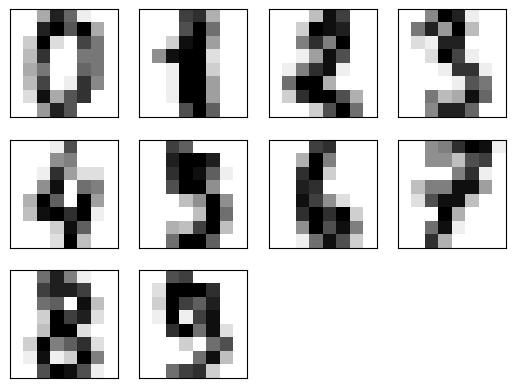

In [475]:
plt.gray()
for i in range(10):
    plt.subplot(3,4,i+1)
    plt.imshow(digits.images[i], cmap='binary', interpolation='nearest')
    plt.xticks([])
    plt.yticks([])
plt.show()

# 2. Кластеризация и оценка качества

Мы будем использовать два популярных алгоритма: иерархическую кластеризацию и метод $K$ средних ($K$-means clustering). Эти и другие алгоритмы кластеризации доступны в библиотеке scikit-learn в подмодуле `cluster`. Иерархическая кластеризация называется `AgglomerativeClustering`, а метод $K$ средних – `KMeans`.

Интерфейс у большинства алгоритмов в scikit-learn простой и единообразный:
- Чтобы инициализировать модель, нужно создать экземпляр соответствующего класса со всеми необходимыми параметрами. Например, у кластеризаций единственный обязательный параметр называется `n_clusters`, это количество кластеров, которое мы хотим получить на выходе.
- Инициализированную модель можно обучить, вызвав метод `fit`.
- С помощью обученной модели можно предсказывать, вызывая метод `predict`.

Как видно, этот интерфейс хорош только для задач обучения с учителем, в которых чётко разделены фазы обучения модели и предсказания с её помощью. У кластеризаций зато есть метод `fit_predict`, который разбивает входную выборку на кластеры и сразу же возвращает результаты разбиения.

Используя каждый из двух методов, иерархическую кластеризацию и $K$ средних, получите разбиение массива `X` на 10 кластеров.

*Указания:*
- Оба раза должен получиться массив из 1797 чисел – номеров кластеров.
- `KMeans` делает несколько (по умолчанию 10) запусков со случайными центрами и из полученных разбиений выводит лучшее в терминах среднего внутрикластерного расстояния. Чтобы улучшить качество предсказаний, можно увеличить число запусков, например, до 100. Это параметр `n_init` в конструкторе.

In [476]:
from sklearn.cluster import AgglomerativeClustering, KMeans

In [477]:
clustering = AgglomerativeClustering(n_clusters=10)
clustering.fit_predict(x)


array([7, 9, 4, ..., 4, 1, 4], dtype=int64)

In [478]:
kmeans = KMeans(n_init = 100,n_clusters=10)
kmeans.fit_predict(x)
y_kmeans = kmeans.predict(x)
y_kmeans

array([5, 7, 7, ..., 7, 3, 3])

Визуализируйте центры кластеров, полученных каждым из двух способов. Это опять должны быть картинки на сетке 3 $\times$ 4 с белым фоном и тёмными контурами. Прокомментируйте: какой из двух алгоритмов даёт центры кластеров, больше похожие на типичные начертания цифр?

*Указания:*
- Центр кластера – это среднее по всем наблюдениям, входящим в кластер, т. е. по какому-то набору строк из `X`.
- Чтобы выбрать наблюдения, входящие в кластер номер `i`, используйте индексацию по булевозначной маске. Саму маску можно получить из массива предсказанных номеров кластеров и числа `i` оператором `==`.
- Усреднять NumPy-массив вдоль какой-нибудь из осей умеет функция `np.mean`. Ознакомьтесь со справкой к ней. Нам нужно усреднение по строкам.

In [479]:
centers = kmeans.cluster_centers_

In [480]:
centers[1]

array([ 0.00000000e+00,  2.22044605e-16,  2.90909091e-01,  7.11515152e+00,
        1.19818182e+01,  1.94545455e+00,  1.51515152e-01,  5.45454545e-02,
        2.60208521e-18,  1.21212121e-02,  3.24848485e+00,  1.38000000e+01,
        8.50909091e+00,  1.50303030e+00,  9.27272727e-01,  2.78787879e-01,
        1.30104261e-18,  6.30303030e-01,  1.06787879e+01,  1.16121212e+01,
        4.32727273e+00,  5.20000000e+00,  3.86666667e+00,  3.27272727e-01,
        6.06060606e-03,  4.74545455e+00,  1.47575758e+01,  5.89090909e+00,
        6.83636364e+00,  1.07636364e+01,  6.22424242e+00,  1.81818182e-02,
        0.00000000e+00,  8.92121212e+00,  1.48181818e+01,  9.35757576e+00,
        1.27939394e+01,  1.43878788e+01,  5.47272727e+00,  0.00000000e+00,
        9.69696970e-02,  6.50303030e+00,  1.16606061e+01,  1.23212121e+01,
        1.48606061e+01,  1.08000000e+01,  1.57575758e+00,  1.38777878e-17,
        6.06060606e-02,  1.12121212e+00,  3.00000000e+00,  7.72727273e+00,
        1.41393939e+01,  

In [481]:
cen_cl = np.array([x[clustering.fit_predict(x) == i].mean(axis=0) for i in range(10)])

In [529]:
cen_cl

array([[0.00000000e+00, 9.72375691e-01, 9.96132597e+00, 1.31104972e+01,
        1.40110497e+01, 1.22486188e+01, 4.11049724e+00, 4.41988950e-02,
        5.52486188e-03, 4.02762431e+00, 1.48232044e+01, 1.19668508e+01,
        8.21546961e+00, 6.24861878e+00, 2.10497238e+00, 3.31491713e-02,
        0.00000000e+00, 5.76243094e+00, 1.43922652e+01, 5.66298343e+00,
        1.92265193e+00, 5.63535912e-01, 4.97237569e-02, 0.00000000e+00,
        0.00000000e+00, 5.47513812e+00, 1.44088398e+01, 1.21436464e+01,
        8.92817680e+00, 4.06077348e+00, 3.86740331e-01, 0.00000000e+00,
        0.00000000e+00, 1.93922652e+00, 7.62430939e+00, 8.47513812e+00,
        8.88397790e+00, 7.48618785e+00, 1.78453039e+00, 0.00000000e+00,
        0.00000000e+00, 2.26519337e-01, 1.14364641e+00, 3.75690608e+00,
        7.55248619e+00, 8.01657459e+00, 2.32044199e+00, 0.00000000e+00,
        0.00000000e+00, 8.01104972e-01, 5.70165746e+00, 8.29834254e+00,
        1.08508287e+01, 7.13259669e+00, 1.31491713e+00, 0.000000

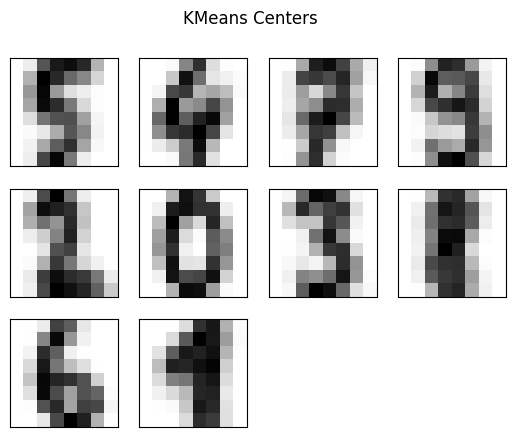

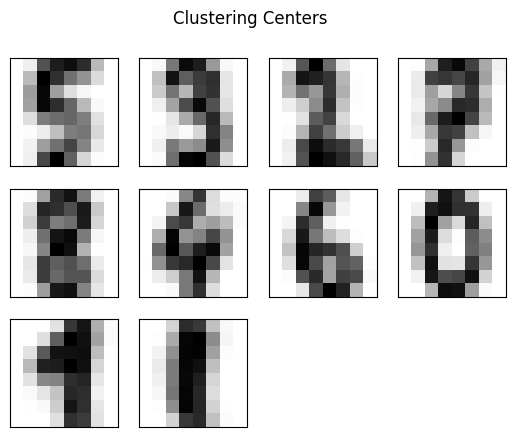

In [482]:
plt.gray()
for i in range(10):
    plt.subplot(3,4,i+1)
    plt.imshow(centers[i].reshape(8,8), cmap='binary', interpolation='nearest')
    plt.xticks([])
    plt.yticks([])
plt.suptitle('KMeans Centers')
plt.show()

for i in range(10):
    plt.subplot(3,4,i+1)
    plt.imshow(cen_cl[i].reshape(8,8), cmap='binary', interpolation='nearest')
    plt.xticks([])
    plt.yticks([])
plt.suptitle('Clustering Centers')
plt.show()

В ситуации, когда истинное число кластеров неизвестно, подбирают оптимальное число кластеров. При этом учитывают две величины: внутрикластерное расстояние (чем меньше, тем лучше) и межкластерное расстояние (чем больше, тем лучше). Так как две эти величины не достигают оптимума одновременно, обычно оптимизируют какой-нибудь функционал от них. Один популярный функционал называется "силуэт" (silhouette). Вот как он вычисляется.

Пусть $X$ – множество наблюдений, $M \subset X$ – один из кластеров, на которые оно разбито в результате кластеризации, $\rho$ – метрика на $X$. Выберем какое-нибудь одно наблюдение $x \in M$. Обозначим $a(x)$ среднее расстояние от $x$ до точек $x'$ из того же кластера:
$$
a(x) = \frac{1}{|M|} \sum_{x' \in M} \rho(x,\, x')
$$

Обозначим $b(x)$ минимум средних расстояний от $x$ до точек $x''$ из какого-нибудь другого кластера $N$:
$$
b(x) = \min_{N \ne M} \frac{1}{|N|} \sum_{x'' \in N} \rho(x,\, x'')
$$

Силуэт – это разность межкластерного и внутрикластерного расстояний, нормированная до отрезка $[-1,\, 1]$ и усреднённая по всем наблюдениям:
$$
\frac{1}{|X|} \sum_{x \in X} \frac{b(x) - a(x)}{\max(a(x),\, b(x))}
$$

В scikit-learn силуэт считается функцией `silhouette_score` из подмодуля `metrics`. На вход нужно передать массив наблюдений и результат кластеризации.


Для числа $K$ от 2 до 20 включительно получите разбиение массива `X` на $K$ кластеров каждым из двух методов. Посчитайте силуэт. Посчитанные значения силуэта сохраните в переменную и визуализируйте в виде графика в координатах: число $K$ – значение силуэта. При каком числе кластеров достигается максимум силуэта?

*Указания:*
- Не забудьте, что функция `range` не захватывает правый конец диапазона.
- Под значения силуэта можно завести два списка: один для иерархической кластеризации, другой для $K$ средних.
- Рисовать графики умеет функция `plt.plot`. Ознакомьтесь со справкой к ней.
- На одной картинке можно разместить несколько графиков, это просто несколько последовательных вызовов `plt.plot`.
- Чтобы добавить легенду (подписи к графикам), можно воспользоваться функцией `plt.legend`. Местоположение легенды контролируется параметром `loc`.
- Чтобы подписать координатные оси, можно воспользоваться функциями `plt.xlabel` и `plt.ylabel`.

In [483]:
from sklearn.metrics import silhouette_score

In [484]:
sl_km = []

for i in range(2,21):
    km = KMeans(n_clusters=i,random_state=0)
    clust = km.fit_predict(x)
    
    sl_km.append(silhouette_score(x,clust)) 


In [485]:
clustering = AgglomerativeClustering(n_clusters=10)
clustering.fit_predict(x)


array([7, 9, 4, ..., 4, 1, 4], dtype=int64)

In [486]:
sl_cl = []
for i in range(2,21):
    cl = AgglomerativeClustering(n_clusters= i)
    clust = cl.fit_predict(x)

    sl_cl.append(silhouette_score(x,clust))
    
    

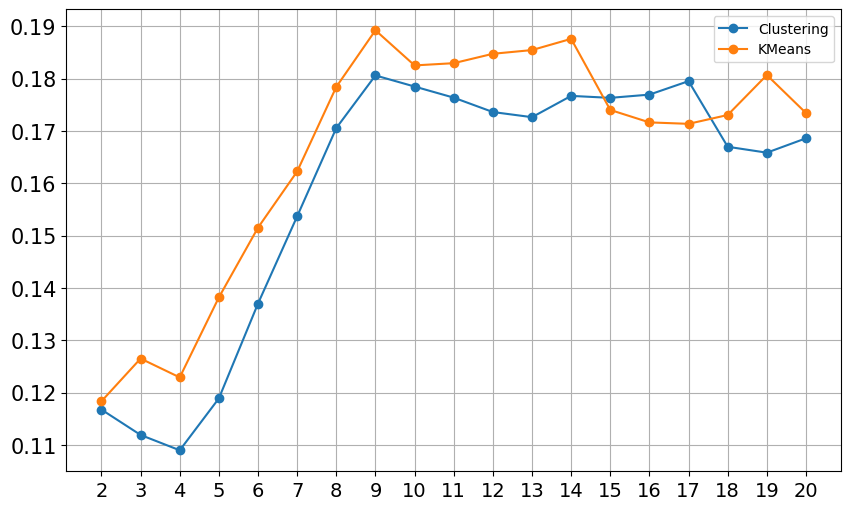

In [487]:
plt.figure(figsize=(10, 6))
plt.plot([i for i in range(2,21)],  sl_cl,label='Clustering', marker='o')
plt.plot([i for i in range(2,21)],  sl_km,label='KMeans', marker='o')
plt.grid(True)
plt.legend()
plt.xticks([i for i in range(2,21)],fontsize=14)
plt.yticks(fontsize=15)
plt.show()

Когда известно "правильное" (в каком-нибудь смысле) разбиение на кластеры, результат кластеризации можно сравнить с ним, используя такие меры, как однородность (homogeneity), полнота (completeness) и их среднее гармоническое – $V$-мера. Определения этих величин довольно громоздкие и основаны на понятии [энтропии распределения вероятностей](https://ru.wikipedia.org/wiki/Информационная_энтропия); подробности излагаются в [этой статье](http://aclweb.org/anthology/D/D07/D07-1043.pdf). На практике достаточно знать, что однородность, полнота и $V$-мера заключены между нулём и единицей – чем больше, тем лучше.

Так как мы знаем, какую цифру на самом деле изображает каждая картинка (это массив `y`), мы можем использовать однородность, полноту и $V$-меру для оценки качества кластеризации. Функции для вычисления этих величин доступны в scikit-learn, в подмодуле `metrics`, под названиями `homogeneity_score`, `completeness_score`, `v_measure_score`. Как вариант, можно использовать функцию `homogeneity_completeness_v_measure`, которая возвращает сразу тройку чисел.

Повторите предыдущее задание, используя $V$-меру вместо силуэта. При каком числе кластеров достигается максимум $V$-меры?

In [488]:
from sklearn.metrics import v_measure_score

In [489]:
v_meas_cl = []
for i in range(2,21):
    cl = AgglomerativeClustering(n_clusters= i)
    clust = cl.fit_predict(x)

    v_meas_cl.append(v_measure_score(y,clust))

In [490]:
v_meas_km = []
for i in range(2,21):
    km = KMeans(n_clusters= i)
    clust = km.fit_predict(x)

    v_meas_km.append(v_measure_score(y,clust))

In [491]:
range(2,21)[np.argmax(v_meas_cl)]

12

In [492]:
range(2,21)[np.argmax(v_meas_km)]

19

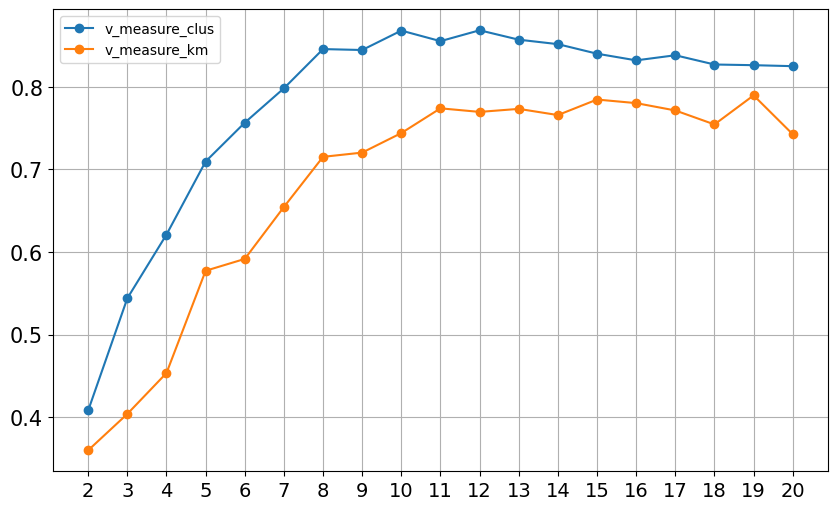

In [493]:
plt.figure(figsize=(10, 6))
plt.plot([i for i in range(2,21)],  v_meas_cl,label='v_measure_clus', marker='o')
plt.plot([i for i in range(2,21)],  v_meas_km,label='v_measure_km', marker='o')
plt.grid(True)
plt.legend()
plt.xticks([i for i in range(2,21)],fontsize=14)
plt.yticks(fontsize=15)
plt.show()

# 3. Снижение размерности признакового пространства

Иногда, особенно когда признаков много и не все они одинаково информативные, бывает полезно снизить размерность признакового пространства, то есть вместо $d$ исходных признаков перейти к рассмотрению $d' \ll d$ новых признаков. Данные были представлены матрицей $n$ наблюдений $\times$ $d$ исходных признаков, а теперь будут представлены матрицей $n$ наблюдений $\times$ $d'$ новых признаков.

Есть два популярных подхода к снижению размерности:
- отобрать (select) новые признаки из числа имеющихся;
- извлечь (extract) новые признаки, преобразуя старые, например, сделать $d'$ различных линейных комбинаций столбцов исходной матрицы $n \times d$.

Одним из широко используемых методов извлечения признаков является сингулярное разложение матрицы (singular value decomposition, SVD). Этот метод позволяет сконструировать любое число $d' \le d$ новых признаков таким образом, что они будут, в определённом смысле, максимально информативными. Математические детали сейчас не важны; познакомиться с ними можно, например, [здесь](https://www.coursera.org/learn/mathematics-and-python/lecture/L9bCV/razlozhieniia-matrits-v-proizviedieniie-singhuliarnoie-razlozhieniie)
(по-русски) или [здесь](https://www.youtube.com/watch?v=P5mlg91as1c) (по-английски).

В scikit-learn есть несколько реализаций сингулярного разложения. Мы будем использовать класс `TruncatedSVD` из подмодуля `decomposition`. В конструктор этого класса достаточно передать один параметр `n_components` – желаемое число новых признаков. Метод `fit_transform` принимает матрицу и возвращает новую матрицу с таким же количеством строк, как прежде, и количеством столбцов, равным числу новых признаков.

*<u>Замечание:</u>* Сингулярное разложение матрицы $M$ обычно пишут в виде $M = U \Sigma V^{*}$, где $U$, $\Sigma$ и $V$ – некие матрицы с хорошими свойствами. То, что возвращает алгоритм `TruncatedSVD`, – это сколько-то (сколько мы хотим получить) первых столбцов матрицы $U$.

Выполните сингулярное разложение матрицы `X`, оставляя 2, 5, 10, 20 признаков. В каждом случае выполните иерархическую и $K$-means кластеризацию преобразованных данных (число кластеров примите равным 10). Посчитайте значения силуэта и $V$-меры. Удалось ли при каком-нибудь $d'$ получить силуэт и / или $V$-меру лучше, чем на исходных данных?

In [494]:
from sklearn.decomposition import TruncatedSVD

In [495]:

sil_cl = []
sil_km = []
v_meas_cl_ = []
v_meas_km_ = []

for i in [2,5,10,20]:
    svd = TruncatedSVD(n_components=i,  random_state=0)
    X_transformed = svd.fit_transform(x)

    cl = AgglomerativeClustering(n_clusters=10)
    cl_predict = cl.fit_predict(X_transformed)

    km = KMeans(n_clusters=10,random_state=0)
    km_predict = km.fit_predict(X_transformed)

    sil_cl.append(silhouette_score(x,cl_predict))
    sil_km.append(silhouette_score(x,km_predict))

    v_meas_cl_.append(v_measure_score(y,cl_predict))
    v_meas_km_.append(v_measure_score(y,km_predict))

   

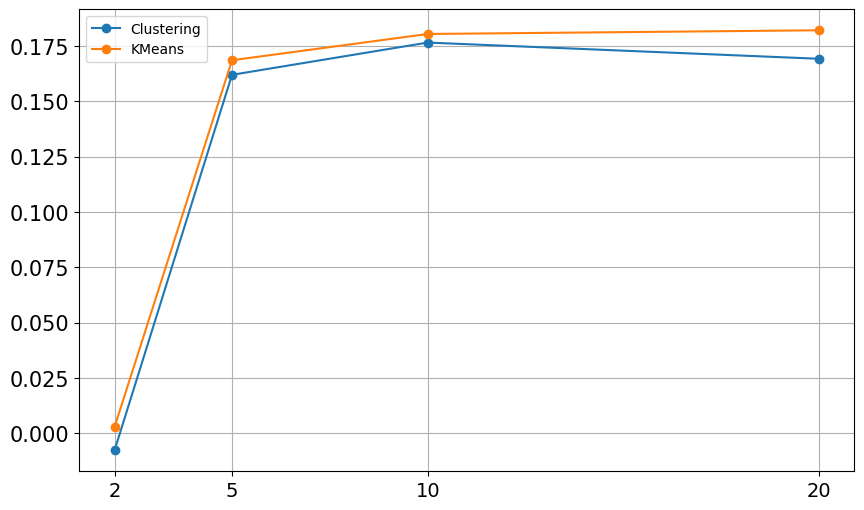

In [496]:
plt.figure(figsize=(10, 6))
plt.plot([2,5,10,20],  sil_cl,label='Clustering', marker='o')
plt.plot([2,5,10,20],  sil_km,label='KMeans', marker='o')
plt.grid(True)
plt.legend()
plt.xticks([2,5,10,20],fontsize=14)
plt.yticks(fontsize=15)
plt.show()

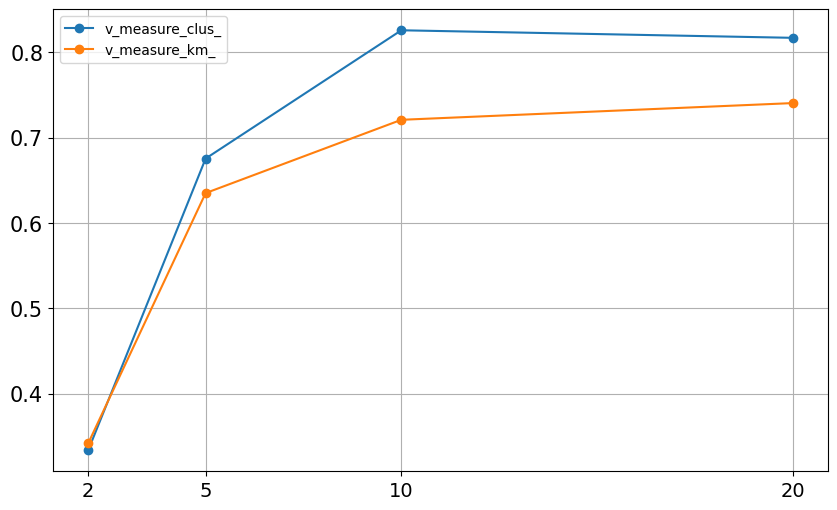

In [497]:
plt.figure(figsize=(10, 6))
plt.plot([2,5,10,20],  v_meas_cl_,label='v_measure_clus_', marker='o')
plt.plot([2,5,10,20],  v_meas_km_,label='v_measure_km_', marker='o')
plt.grid(True)
plt.legend()
plt.xticks([2,5,10,20],fontsize=14)
plt.yticks(fontsize=15)
plt.show()

сравниваем значения для 10 кластеров 

In [498]:
print(sil_cl[2])
print(sl_cl[11])

0.1765881132796084
0.1726407155529682


In [499]:
print(sil_km[2])
print(sl_km[11])

0.18046559934052703
0.18547034333157764


In [500]:
print(v_meas_cl_[2])
print(v_meas_cl[11])

0.8259753348813226
0.8571580830709692


In [501]:
print(v_meas_km_[2])
print(v_meas_km[11])

0.7210502822790584
0.7733791478884064


Другая популярная техника снижения размерности, которая особенно хорошо подходит для работы с картинками, – это алгоритм t-distributed stochastic neighbor embeddings, сокращённо tSNE. В отличие от сингулярного разложения, это преобразование нелинейное. Его основная идея – отобразить точки из пространства размерности $d$ в пространство размерности 2 или 3 (обычно 2, то есть на плоскость) таким образом, чтобы как можно точнее сохранить расстояния. Математические детали есть, например, [здесь](https://en.wikipedia.org/wiki/T-distributed_stochastic_neighbor_embedding), но они нетривиальны.

В библиотеке scikit-learn реализацией tSNE является класс `TSNE` в подмодуле `manifold`. В конструктор можно передать параметр `n_components`, а можно и не передавать: по умолчанию он равен 2. Метод `fit_transform` работает аналогично тому, как и у `TruncatedSVD`.


Выполните tSNE-преобразование матрицы `X`, оставив 2 признака. Визуализируйте данные, преобразованные таким образом, в виде точечной диаграммы: первый признак вдоль горизонтальной оси, второй признак вдоль вертикальной оси. Подсветите разными цветами группы точек, соответствующих разным цифрам.

*Указания:*
- Точечную диаграмму умеет рисовать функция `plt.scatter`. Ознакомьтесь со справкой к ней.
- За цвета точек отвечает параметр `c` у функции `plt.scatter`. Передать в него надо истинные метки классов.

In [502]:
from sklearn.manifold import TSNE

In [576]:
tsne = TSNE()

In [577]:
x_tsne = tsne.fit_transform(x)

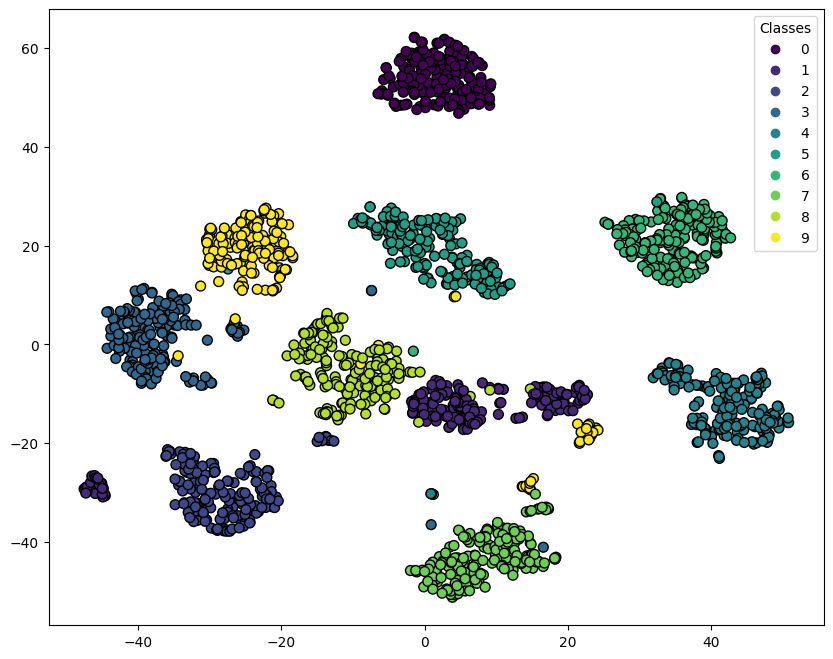

In [505]:
plt.figure(figsize=(10, 8))
plt.scatter(x_tsne[:,0],x_tsne[:,1],c=y, cmap='viridis',edgecolors='k',  s=50)
legend = plt.legend(*scatter.legend_elements(), title='Classes', loc='upper right')
plt.show()

Для tSNE-преобразованных данных с 2 признаками выполните иерархическую и $K$-means кластеризацию (число кластеров примите равным 10). Посчитайте значения силуэта и $V$-меры. Удалось ли получить силуэт и / или $V$-меру лучше, чем на исходных данных?

In [506]:
cl_predict_tsne = cl.fit_predict(x_tsne)
km_predict_tsne = km.fit_predict(x_tsne)

sil_cl_tsne = silhouette_score(x_tsne,cl_predict_tsne)
sil_km_tsne = silhouette_score(x_tsne,km_predict_tsne)

v_meas_cl_tsne = v_measure_score(y,cl_predict_tsne)
v_meas_km_tsne = v_measure_score(y,km_predict_tsne)

print(f"Silhouette (t-SNE + Hierarchical): {sil_cl_tsne}")
print(f"V-Measure (t-SNE + Hierarchical): {v_meas_cl_tsne}")
print(f"Silhouette (t-SNE + KMeans): {sil_km_tsne}")
print(f"V-Measure (t-SNE + KMeans): {v_meas_km_tsne}")

Silhouette (t-SNE + Hierarchical): 0.6390450596809387
V-Measure (t-SNE + Hierarchical): 0.9110565553465931
Silhouette (t-SNE + KMeans): 0.6428404450416565
V-Measure (t-SNE + KMeans): 0.9116334462095017


Для самого лучшего разбиения, которое вам удалось получить (на ваше усмотрение, лучшего в терминах силуэта или $V$-меры), опять визуализируйте картинками центры кластеров. Удалось ли добиться, чтобы каждый кластер соответствовал какой-нибудь одной цифре?

In [507]:
print(v_meas_cl[11])
print(v_meas_cl_[2])
print(v_meas_cl_tsne)

0.8571580830709692
0.8259753348813226
0.9110565553465931


In [578]:
kmeans_clustering = KMeans(n_clusters=10, n_init=100)
kmeans_labels_X_tsne = kmeans_clustering.fit_predict(x_tsne)

In [579]:
cen = np.array([x[kmeans_labels_X_tsne == i].mean(axis=0) for i in range(10)])

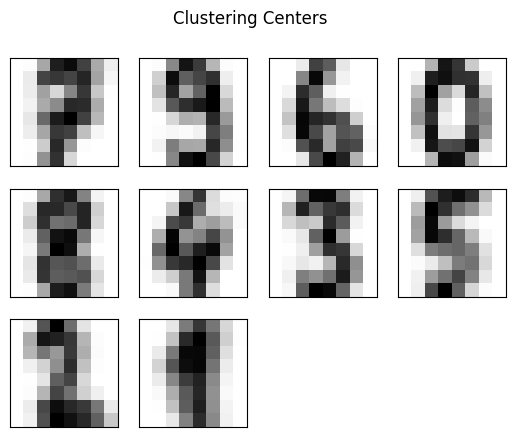

In [580]:
for i in range(10):
    plt.subplot(3,4,i+1)
    plt.imshow(cen[i].reshape(8,8), cmap='binary', interpolation='nearest')
    plt.xticks([])
    plt.yticks([])
plt.suptitle('Clustering Centers')
plt.show()

ничего не напоминает исходные значение

# 4. Итоги

Напишите в свободной форме, какие выводы вы сделали из выполненной работы. Ответьте, как минимум, на следующие два вопроса:
- Какой из двух методов даёт более осмысленные кластеры – иерархическая кластеризация или алгоритм $K$ средних? Зависит ли это от настроек каждого алгоритма? От критериев оценивания качества?
- Удаётся ли улучшить качество кластеризации, снижая размерность признакового пространства?

 при использовании t-SNE для снижения размерности, иерархическая кластеризация демонстрировала лучшие результаты по сравнению с K средними, особенно в терминах V-меры.
 t-SNE показало более высокую V-меру по сравнению с TruncatedSVD

Скачайте датасет [MNIST Handwritten Digits](http://yann.lecun.com/exdb/mnist). Как сделать это с помощью scikit-learn, написано [здесь](http://scikit-learn.org/stable/datasets/index.html#downloading-datasets-from-the-mldata-org-repository). MNIST Handwritten Digits – это 70 тысяч распознанных рукописных изображений цифр, каждое размером 28 $\times$ 28 пикселей. Попробуйте прокластеризовать этот датасет и добиться как можно лучших значений силуэта и $V$-меры.